In [1]:
import uproot
print("uproot version: ", uproot.__version__)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import pickle


uproot version:  5.0.5


# Load Ntuple File

In [2]:
# https://docs.google.com/spreadsheets/d/1AVrUfAffE6mQw5t-gQnlXxxcyhwVxtPGGUp_7c1MT2w

# older file
# downloaded from /exp/uboone/data/users/eyandel/combined_reco/mcc910_test/processed_checkout_root_files/MCC9.10_Test_Samples_v10_04_07_04_Run4b_super_unified_reco2_BNB_nu_NC_pi0_overlay_reco2_hist.root
# BNB NC Pi0 super-unified ntuple, with WC post-processing
#f = uproot.open("data_files/MCC9.10_Test_Samples_v10_04_07_04_Run4b_super_unified_reco2_BNB_nu_NC_pi0_overlay_reco2_hist.root")

# newer file, blips and nugraph messed up
# downloaded from /exp/uboone/data/users/eyandel/combined_reco/mcc910_test/processed_checkout_root_files/SURPRISE_Test_Samples_v10_04_07_05_Run4b_super_unified_reco2_BNB_nu_NC_pi0_overlay_reco2_hist.root
# BNB NC Pi0 super-unified ntuple, with WC post-processing
#f = uproot.open("data_files/SURPRISE_Test_Samples_v10_04_07_05_Run4b_super_unified_reco2_BNB_nu_NC_pi0_overlay_reco2_hist.root")

# newer file, WC BDT scores missing
# downloaded from /exp/uboone/data/uboonepro/MCC9.10/v10_04_07_05/SURPRISE_Test_Samples_v10_04_07_05_Run4b_super_unified_pelee_reco2_BNB_nu_NC_pi0_overlay_reprocess_ntuple.root
# BNB NC Pi0 super-unified ntuple
#f = uproot.open("data_files/SURPRISE_Test_Samples_v10_04_07_05_Run4b_super_unified_pelee_reco2_BNB_nu_NC_pi0_overlay_reprocess_ntuple.root")

# newer file, includes more blips
f = uproot.open("data_files/SURPRISE_Test_Samples_v10_04_07_05_Run4b_hyper_unified_reco2_BNB_nu_NC_pi0_overlay_may8_reco2_hist_62280465_snapshot.root")


In [3]:
f["wcpselection"]["T_PFeval"].items()

[('run', <TBranch 'run' at 0x0003148a6c80>),
 ('subrun', <TBranch 'subrun' at 0x0003148a7b20>),
 ('event', <TBranch 'event' at 0x0003148e4310>),
 ('neutrino_type', <TBranch 'neutrino_type' at 0x0003148e4ac0>),
 ('reco_nuvtxX', <TBranch 'reco_nuvtxX' at 0x0003148e5270>),
 ('reco_nuvtxY', <TBranch 'reco_nuvtxY' at 0x0003148e5a20>),
 ('reco_nuvtxZ', <TBranch 'reco_nuvtxZ' at 0x0003148e61d0>),
 ('reco_showervtxX', <TBranch 'reco_showervtxX' at 0x0003148e6980>),
 ('reco_showervtxY', <TBranch 'reco_showervtxY' at 0x0003148e7130>),
 ('reco_showervtxZ', <TBranch 'reco_showervtxZ' at 0x0003148e78e0>),
 ('reco_showerKE', <TBranch 'reco_showerKE' at 0x0003148fc0d0>),
 ('reco_muonvtxX', <TBranch 'reco_muonvtxX' at 0x0003148fc880>),
 ('reco_muonvtxY', <TBranch 'reco_muonvtxY' at 0x0003148fd030>),
 ('reco_muonvtxZ', <TBranch 'reco_muonvtxZ' at 0x0003148fd7e0>),
 ('reco_muonMomentum', <TBranch 'reco_muonMomentum' at 0x0003148fdf90>),
 ('nuvtx_diff', <TBranch 'nuvtx_diff' at 0x0003148fe740>),
 ('showe

# Load Wire-Cell Variables

In [4]:
T_bdt_vars = [              # variables involved with BDT training (if you want to train your own BDT, lots of these variables will be useful)
                            # many of these variables describe specific features of the WC spacepoints using this code: https://github.com/BNLIF/wire-cell-pid/blob/master/src/NeutrinoID_nue_tagger.h
                            # here, we just include higher level outputs:
    "nue_score",                    # BDT score for nue selection, used for the WC inclusive nueCC analysis
    "numu_score",                   # BDT score for numu selection, used for the WC inclusive numuCC selections
    "nc_delta_score",               # BDT score for NC Delta selection
    "nc_pio_score",                 # BDT score for NC pi0 selection
    "numu_cc_flag",                 # flag, -1 means not generic selected, 0 means generic selected, 1 means cut-based numuCC selected. We often use "numu_cc_flag >= 0" to apply generic neutrino selection.
]

T_eval_vars = [             # variables involved with low level reconstruction and truth information
    "run",                          # run number
    "subrun",                       # subrun number
    "event",                        # event number
    "match_isFC",                   # reconstructed cluster is fully contained (FC), boolean
    "truth_nuEnergy",               # true neutrino energy (MeV)
    "truth_nuPdg",                  # true neutrino pdg code
    "truth_isCC",                   # true interaction type is charged current, boolean
    "match_completeness_energy",    # the true energy deposited in the clusters that are 3D-matched with the reconstructed neutrino clusters (MeV)
    "truth_energyInside",           # the true energy deposited in the TPC Fiducial Volume (MeV)
    "truth_vtxInside",              # boolean, true neutrino vertex is inside the TPC Fiducial Volume
    "weight_cv",                    # GENIE MicroBooNE tune event weight (which should be corrected by also using weight_spline)
    "weight_spline",                # additional weight to correct the GENIE tune for certain events
]
T_eval_data_vars = [        # same as above, but for data files we do not attempt to load any truth information
    "run",
    "subrun",
    "event",
    "match_isFC",
]

T_kine_vars = [             # variables involved with kinematic reconstruction
    "kine_reco_Enu",                # reconstructed neutrino energy (MeV). "kine_reco_Enu > 0" is another way to apply generic neutrino selection.
    "kine_energy_particle",         # energy of each reco particle
    "kine_particle_type",           # pdg code of each reco particle
]

T_pf_vars = [               # variables involved with individual particles
    "truth_NprimPio",
    "truth_NCDelta",
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",
    "reco_muonMomentum",            # reconstructed muon momentum 4-vector (p_x, p_y, p_z, p_t), in (GeV/c, GeV/c, GeV/c, GeV)
    "reco_showerMomentum",          # reconstructed primary shower momentum 4-vector (p_x, p_y, p_z, p_t), in (GeV/c, GeV/c, GeV/c, GeV)
    "reco_showervtxX",
    "reco_showervtxY",
    "reco_showervtxZ",
    "truth_vtxX",                   # true neutrino vertex x (cm)
    "truth_vtxY",                   # true neutrino vertex y (cm)
    "truth_vtxZ",                   # true neutrino vertex z (cm)
    "truth_corr_nuvtxX",            # true neutrino vertex x (cm), corrected for SCE
    "truth_corr_nuvtxY",            # true neutrino vertex y (cm), corrected for SCE
    "truth_corr_nuvtxZ",            # true neutrino vertex z (cm), corrected for SCE

    # These variables are related to individual true particles
    "truth_Ntrack",
    "truth_id",
    "truth_pdg",
    "truth_mother",
    "truth_startMomentum",
    "truth_startXYZT",
    "truth_endXYZT",

    # These variables are related to individual reco particles
    "reco_Ntrack",
    "reco_id",
    "reco_pdg",
    "reco_mother",
    "reco_startMomentum",
    "reco_startXYZT",
    "reco_endXYZT",
]

T_pf_data_vars = [          # same as above, but for data files we do not attempt to load any truth information
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",
    "reco_muonMomentum",
    "reco_showerMomentum",
    "reco_showervtxX",
    "reco_showervtxY",
    "reco_showervtxZ",
    "reco_Ntrack",
    "reco_id",
    "reco_pdg",
    "reco_mother",
    "reco_startMomentum",
    "reco_startXYZT",
    "reco_endXYZT",
]

T_spacepoints_vars = [
    "Trec_spacepoints_x",
    "Trec_spacepoints_y",
    "Trec_spacepoints_z",
    "Trec_spacepoints_q",
    "Treccharge_spacepoints_x",
    "Treccharge_spacepoints_y",
    "Treccharge_spacepoints_z",
    "Treccharge_spacepoints_q",
    "Trecchargeblob_spacepoints_x",
    "Trecchargeblob_spacepoints_y",
    "Trecchargeblob_spacepoints_z",
    "Trecchargeblob_spacepoints_q",
]

vars = {}
vars.update(f["wcpselection"]["T_BDTvars"].arrays(T_bdt_vars, library="np"))
vars.update(f["wcpselection"]["T_eval"].arrays(T_eval_vars, library="np"))
vars.update(f["wcpselection"]["T_KINEvars"].arrays(T_kine_vars, library="np"))
vars.update(f["wcpselection"]["T_PFeval"].arrays(T_pf_vars, library="np"))
vars.update(f["wcpselection"]["T_spacepoints"].arrays(T_spacepoints_vars, library="np"))
file_POT = np.sum(f["wcpselection"]["T_pot"].arrays("pot_tor875good", library="np")["pot_tor875good"])
for col in vars:
    vars[col] = vars[col].tolist()
wc_df = pd.DataFrame(vars)

wc_df


,nue_score,numu_score,nc_delta_score,nc_pio_score,numu_cc_flag,run,subrun,event,match_isFC,truth_nuEnergy,...,Trec_spacepoints_z,Trec_spacepoints_q,Treccharge_spacepoints_x,Treccharge_spacepoints_y,Treccharge_spacepoints_z,Treccharge_spacepoints_q,Trecchargeblob_spacepoints_x,Trecchargeblob_spacepoints_y,Trecchargeblob_spacepoints_z,Trecchargeblob_spacepoints_q
0,-15.000000,-0.445759,-3.342609,3.510125,0.0,20290,30,1510,True,1415.797485,...,"[140.50006103515625, 139.45, 139.45, 140.35, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[251.7494873046875, 235.4072265625, 251.749487...","[-69.978857421875, -48.783514404296874, -69.97...","[200.29296875, 139.72479248046875, 200.2929687...","[10176.487498767021, 2227.6691970849224, 10176...","[200.3164306640625, 190.87120361328124, 197.43...","[6.122476196289062, -85.38410034179688, 11.928...","[100.37066040039062, 148.0973876953125, 102.44...","[1354.4931984723416, 5766.427035282989, 5534.6..."
1,-8.405992,-0.906318,-6.305526,3.168464,0.0,20290,30,1521,True,2649.550049,...,"[225.7001953125, 226.299853515625, 226.6000976...","[15000.0, 15000.0, 15000.0, 15000.0, 15000.0, ...","[156.13887939453124, 159.79669189453125, 155.0...","[-22.46339569091797, -25.446536254882812, -19....","[221.5751953125, 224.2154541015625, 221.345898...","[3382.700027173083, 10343.172487126567, 12377....","[156.13887939453124, 150.70679931640626, 146.8...","[-22.46339569091797, -20.916307067871095, 15.0...","[221.5751953125, 235.475146484375, 228.55, 228...","[3382.700027173083, 2578.491589913845, 701.602..."
2,-15.000000,1.700583,-0.913104,-0.312040,0.0,20290,30,1537,False,840.083069,...,"[256.45, 257.05, 257.35, 257.35, 257.35, 258.2...","[15000.0, 15000.0, 15000.0, 15000.0, 15000.0, ...","[41.76905517578125, 43.013720703125, 41.769055...","[-46.594601440429685, -46.71944580078125, -46....","[276.25, 276.386083984375, 276.25, 276.3180419...","[5001.318556364506, 17769.44923867893, 5001.31...","[43.013720703125, 2.5214696884155274, 1.689658...","[-46.71944580078125, -0.4602956771850586, 9.48...","[276.386083984375, 251.1544677734375, 250.3045...","[17769.44923867893, 390.4527018999145, 3842.96..."
3,-15.000000,-3.821578,-2.275953,-1.729817,-1.0,20290,30,1541,True,1657.857056,...,[],[],[],[],[],[],[],[],[],[]
4,-9.779932,-1.000641,-7.236095,5.160080,0.0,20290,30,1543,False,1086.874634,...,"[417.70009765625, 418.00009765625, 417.85, 417...","[15000.0, 15000.0, 15000.0, 15000.0, 15000.0, ...","[144.645751953125, 153.31810302734374, 153.708...","[80.11556396484374, 89.71154174804687, 89.2836...","[394.5928955078125, 407.3638427734375, 407.206...","[6251.484296407572, 2735.1893085552147, 1264.8...","[144.645751953125, 153.31810302734374, 130.403...","[80.11556396484374, 89.71154174804687, 108.208...","[394.5928955078125, 407.3638427734375, 458.988...","[6251.484296407572, 2735.1893085552147, 623.03..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42996,-5.792249,-1.554321,-1.536520,2.614535,0.0,20360,405,20269,True,881.569336,...,"[467.8, 468.4, 467.8, 468.7, 469.0, 458.8, 459...","[15000.0, 15000.0, 15000.0, 15000.0, 15000.0, ...","[229.6863525390625, 234.51689453125, 234.59587...","[58.49786376953125, 63.98455810546875, 63.6993...","[446.4056640625, 477.608935546875, 477.0870117...","[5173.242848784688, 2681.2947012200007, 2595.7...","[229.6863525390625, 233.1267333984375, 251.057...","[58.49786376953125, 54.19010009765625, 60.2655...","[446.4056640625, 462.84404296875, 450.36464843...","[5173.242848784688, 1955.2752609714703, 4440.4..."
42997,-15.000000,-0.356547,-1.969883,1.781391,0.0,20360,405,20272,False,1582.089722,...,"[814.298828125, 814.598828125, 814.898828125, ...","[15000.0, 15000.0, 15000.0, 15000.0, 15000.0, ...","[92.23675537109375, 92.23675537109375, 91.7604...","[111.45394287109374, 111.45394287109374, 111.7...","[795.885009765625, 795.885009765625, 796.12197...","[4287.510854204034, 4287.510854204034, 3740.52...","[92.23675537109375, 87.392

## Wire-Cell post-processing

In [5]:
# Extra reco variables
proton_nums = []
other_track_nums = []
energy_lists = wc_df["kine_energy_particle"].to_numpy()
pdg_lists = wc_df["kine_particle_type"].to_numpy()
for i in tqdm(range(wc_df.shape[0])):
    proton_num = 0
    other_track_num = 0
    energy_list = energy_lists[i]
    pdg_list = pdg_lists[i]
    for i in range(len(energy_list)):
        if abs(pdg_list[i]) == 2212:
            if energy_list[i] > 35: # 35 MeV reco proton kinetic energy threshold
                proton_num += 1
        if abs(pdg_list[i]) == 13 or abs(pdg_list[i]) == 211: # see N_tracks at https://github.com/BNLIF/wcp-uboone-bdt/blob/main/inc/WCPLEEANA/cuts.h
            if energy_list[i] > 10.:
                other_track_num += 1
    proton_nums.append(proton_num)
    other_track_nums.append(other_track_num)
wc_df["reco_num_protons"] = proton_nums
wc_df["reco_num_other_tracks"] = other_track_nums

# Extra truth variables
max_prim_proton_energies = []
truth_pdgs = wc_df["truth_pdg"].to_numpy()
truth_mothers = wc_df["truth_mother"].to_numpy()
truth_startMomentums = wc_df["truth_startMomentum"].to_numpy()
for i in tqdm(range(wc_df.shape[0])):
    max_prim_proton_energy = 0
    truth_pdg_list = truth_pdgs[i]
    truth_mother_list = truth_mothers[i]
    truth_startMomentum_list = truth_startMomentums[i]
    if isinstance(truth_pdg_list, float) and np.isnan(truth_pdg_list): # doesn't have a truth Geant4 particle tree
        max_prim_proton_energies.append(-1)
        continue
    for j in range(len(truth_pdg_list)):
        if truth_mother_list[j] == 0 and truth_pdg_list[j] == 2212: # primary proton
            max_prim_proton_energy = max(truth_startMomentum_list[j][3] * 1000. - 938.272089, max_prim_proton_energy)
    max_prim_proton_energies.append(max_prim_proton_energy)
wc_df["true_max_prim_proton_energy"] = max_prim_proton_energies

# extra primary shower position and angle variables
shower_thetas = []
shower_phis = []
distances_to_boundary = []
backwards_projected_dists = []
reco_shower_momentum = wc_df["reco_showerMomentum"].to_numpy()
reco_nu_vtx_x = wc_df["reco_showervtxX"].to_numpy()
reco_nu_vtx_y = wc_df["reco_showervtxY"].to_numpy()
reco_nu_vtx_z = wc_df["reco_showervtxZ"].to_numpy()
for i in tqdm(range(wc_df.shape[0])):
    reco_shower_momentum_0 = reco_shower_momentum[i][0]
    reco_shower_momentum_1 = reco_shower_momentum[i][1]
    reco_shower_momentum_2 = reco_shower_momentum[i][2]
    reco_shower_momentum_3 = reco_shower_momentum[i][3]
    if reco_shower_momentum_3 > 0:
        reco_shower_momentum_perp = np.sqrt(reco_shower_momentum_0 * reco_shower_momentum_0 + reco_shower_momentum_1 * reco_shower_momentum_1)
        shower_thetas.append(np.arctan2(reco_shower_momentum_perp, reco_shower_momentum_2) * 180. / np.pi)
        shower_phis.append(np.arctan2(reco_shower_momentum_0, reco_shower_momentum_1) * 180. / np.pi)

        shower_momentum_total_3d = np.sqrt(reco_shower_momentum_0 * reco_shower_momentum_0 + 
                                            reco_shower_momentum_1 * reco_shower_momentum_1 + 
                                            reco_shower_momentum_2 * reco_shower_momentum_2)
        shower_unit_vector_3d = [reco_shower_momentum_0 / shower_momentum_total_3d, 
                                    reco_shower_momentum_1 / shower_momentum_total_3d, 
                                    reco_shower_momentum_2 / shower_momentum_total_3d]
        center_x = 130.
        center_y = 0.
        center_z = 525.    
        towards_center_length = np.sqrt((reco_nu_vtx_x[i] - center_x) * (reco_nu_vtx_x[i] - center_x) + 
                                        (reco_nu_vtx_y[i] - center_y) * (reco_nu_vtx_y[i] - center_y) + 
                                        (reco_nu_vtx_z[i] - center_z) * (reco_nu_vtx_z[i] - center_z))
        towards_center_unit_vector_3d = [(center_x - reco_nu_vtx_x[i]) / towards_center_length, 
                                            (center_y - reco_nu_vtx_y[i]) / towards_center_length, 
                                            (center_z - reco_nu_vtx_z[i]) / towards_center_length]

        shower_momentum_total_2d = np.sqrt(reco_shower_momentum_0 * reco_shower_momentum_0 + 
                                            reco_shower_momentum_1 * reco_shower_momentum_1)
        shower_unit_vector_2d = [reco_shower_momentum_0 / shower_momentum_total_3d, 
                                    reco_shower_momentum_1 / shower_momentum_total_3d]
        towards_center_length = np.sqrt((reco_nu_vtx_x[i] - center_x) * (reco_nu_vtx_x[i] - center_x) + 
                                        (reco_nu_vtx_y[i] - center_y) * (reco_nu_vtx_y[i] - center_y))
        towards_center_unit_vector_2d = [(center_x - reco_nu_vtx_x[i]) / towards_center_length, 
                                            (center_y - reco_nu_vtx_y[i]) / towards_center_length]
        
        min_backwards_projected_dist = 1e9
                
        # projecting to x walls
        if shower_unit_vector_3d[0] > 0:
            min_backwards_projected_dist = min(min_backwards_projected_dist, (reco_nu_vtx_x[i] - (-1)) / shower_unit_vector_3d[0])
        else:
            min_backwards_projected_dist = min(min_backwards_projected_dist, (reco_nu_vtx_x[i] - (254.3)) / shower_unit_vector_3d[0])
            
        # projecting to y walls
        if shower_unit_vector_3d[1] > 0:
            min_backwards_projected_dist = min(min_backwards_projected_dist, (reco_nu_vtx_y[i] - (-115.)) / shower_unit_vector_3d[1])
        else:
            min_backwards_projected_dist = min(min_backwards_projected_dist, (reco_nu_vtx_y[i] - (117.)) / shower_unit_vector_3d[1])
            
        # projecting to z walls
        if shower_unit_vector_3d[2] > 0:
            min_backwards_projected_dist = min(min_backwards_projected_dist, (reco_nu_vtx_z[i] - (0.6)) / shower_unit_vector_3d[2])
        else:
            min_backwards_projected_dist = min(min_backwards_projected_dist, (reco_nu_vtx_z[i] - (1036.4)) / shower_unit_vector_3d[2])

        backwards_projected_dists.append(min_backwards_projected_dist)
        
    else:
        shower_thetas.append(np.nan)
        shower_phis.append(np.nan)
        backwards_projected_dists.append(np.nan)
        
    distances_to_boundary.append(np.min([
        abs(reco_nu_vtx_x[i] - (-1.)),
        abs(reco_nu_vtx_x[i] - (254.3)),
        abs(reco_nu_vtx_y[i] - (-115.)),
        abs(reco_nu_vtx_y[i] - (117.)),
        abs(reco_nu_vtx_z[i] - (0.6)),
        abs(reco_nu_vtx_z[i] - (1036.4))
    ]))
wc_df["reco_shower_theta"] = shower_thetas
wc_df["reco_shower_phi"] = shower_phis
wc_df["reco_distance_to_boundary"] = distances_to_boundary
wc_df["reco_backwards_projected_dist"] = backwards_projected_dists


  0%|          | 0/43001 [00:00<?, ?it/s]

  0%|          | 0/43001 [00:00<?, ?it/s]

  0%|          | 0/43001 [00:00<?, ?it/s]

/var/folders/yg/3cj9svrx2kz3bpv_6thtt7x00000gn/T/ipykernel_20309/3936279833.py:104: RuntimeWarning: divide by zero encountered in double_scalars
  min_backwards_projected_dist = min(min_backwards_projected_dist, (reco_nu_vtx_z[i] - (1036.4)) / shower_unit_vector_3d[2])


# Load Blip Variables

In [6]:
f["nuselection"]["NeutrinoSelectionFilter"].items()

[('selected', <TBranch 'selected' at 0x00044facfc10>),
 ('run', <TBranch 'run' at 0x00044facdf30>),
 ('sub', <TBranch 'sub' at 0x00044face950>),
 ('evt', <TBranch 'evt' at 0x00044faceef0>),
 ('trk_id', <TBranch 'trk_id' at 0x00044facf400>),
 ('shr_id', <TBranch 'shr_id' at 0x0003e2b238b0>),
 ('trk2_id', <TBranch 'trk2_id' at 0x0003e3603280>),
 ('shr2_id', <TBranch 'shr2_id' at 0x0003e3602380>),
 ('trk3_id', <TBranch 'trk3_id' at 0x0003e3600610>),
 ('shr3_id', <TBranch 'shr3_id' at 0x0003e3601060>),
 ('shr_energy_tot', <TBranch 'shr_energy_tot' at 0x0003e3601a20>),
 ('shr_energy', <TBranch 'shr_energy' at 0x0003e1f2bb80>),
 ('shr_energy_second', <TBranch 'shr_energy_second' at 0x0003e1f29300>),
 ('shr_energy_third', <TBranch 'shr_energy_third' at 0x0003e3628c10>),
 ('shr_energy_tot_cali', <TBranch 'shr_energy_tot_cali' at 0x0003e2b32890>),
 ('shr_energy_cali', <TBranch 'shr_energy_cali' at 0x0003e2b33040>),
 ('shr_energy_second_cali',
  <TBranch 'shr_energy_second_cali' at 0x0003e2b3007

In [ ]:
blip_vars = [
    "nblips_saved",
    "blip_x",
    "blip_y",
    "blip_z",
    "blip_dx",
    "blip_dw",
    "blip_energy",
    "blip_charge",
    "blip_nplanes",
    "blip_proxtrkdist",
    "blip_proxtrkid",
    "blip_touchtrk",
    "blip_touchtrkid",
    "blip_pl0_nwires",
    "blip_pl1_nwires",
    "blip_pl2_nwires",
    "blip_pl0_bydeadwire",
    "blip_pl1_bydeadwire",
    "blip_pl2_bydeadwire",
    "blip_true_g4id",
    "blip_true_pdg",
    "blip_true_energy",
]

vars = {}
vars.update(f["nuselection"]["NeutrinoSelectionFilter"].arrays(blip_vars, library="np"))
for col in vars:
    vars[col] = vars[col].tolist()
blip_df = pd.DataFrame(vars)

# adding separate electron blip, proton, and other blip arrays based on blip_true_pdg
electron_blips_x = []
electron_blips_y = []
electron_blips_z = []
electron_blips_energy = []
proton_blips_x = []
proton_blips_y = []
proton_blips_z = []
proton_blips_energy = []
other_blips_x = []
other_blips_y = []
other_blips_z = []
other_blips_energy = []
for event_index in tqdm(range(len(blip_df))):
    electron_blips_x.append([])
    electron_blips_y.append([])
    electron_blips_z.append([])
    electron_blips_energy.append([])
    proton_blips_x.append([])
    proton_blips_y.append([])
    proton_blips_z.append([])
    proton_blips_energy.append([])
    other_blips_x.append([])
    other_blips_y.append([])
    other_blips_z.append([])
    other_blips_energy.append([])
    for blip_index in range(len(blip_df["blip_true_pdg"][event_index])):
        if blip_df["blip_true_pdg"][event_index][blip_index] == 11:
            electron_blips_x[event_index].append(blip_df["blip_x"][event_index][blip_index])
            electron_blips_y[event_index].append(blip_df["blip_y"][event_index][blip_index])
            electron_blips_z[event_index].append(blip_df["blip_z"][event_index][blip_index])
            electron_blips_energy[event_index].append(blip_df["blip_energy"][event_index][blip_index])
        elif blip_df["blip_true_pdg"][event_index][blip_index] == 2212:
            proton_blips_x[event_index].append(blip_df["blip_x"][event_index][blip_index])
            proton_blips_y[event_index].append(blip_df["blip_y"][event_index][blip_index])
            proton_blips_z[event_index].append(blip_df["blip_z"][event_index][blip_index])
            proton_blips_energy[event_index].append(blip_df["blip_energy"][event_index][blip_index])
        else:
            other_blips_x[event_index].append(blip_df["blip_x"][event_index][blip_index])
            other_blips_y[event_index].append(blip_df["blip_y"][event_index][blip_index])
            other_blips_z[event_index].append(blip_df["blip_z"][event_index][blip_index])
            other_blips_energy[event_index].append(blip_df["blip_energy"][event_index][blip_index])

blip_df["electron_blip_x"] = electron_blips_x
blip_df["electron_blip_y"] = electron_blips_y
blip_df["electron_blip_z"] = electron_blips_z
blip_df["electron_blip_energy"] = electron_blips_energy
blip_df["proton_blip_x"] = proton_blips_x
blip_df["proton_blip_y"] = proton_blips_y
blip_df["proton_blip_z"] = proton_blips_z
blip_df["proton_blip_energy"] = proton_blips_energy
blip_df["other_blip_x"] = other_blips_x
blip_df["other_blip_y"] = other_blips_y
blip_df["other_blip_z"] = other_blips_z
blip_df["other_blip_energy"] = other_blips_energy


In [8]:
blip_true_pdg = blip_df["blip_true_pdg"].to_numpy()
flattened_blip_true_pdg = np.array([])
for event_index in tqdm(range(len(blip_true_pdg))):
    flattened_blip_true_pdg = np.append(flattened_blip_true_pdg, blip_true_pdg[event_index])

from collections import Counter

blip_true_pdg_counter = Counter(flattened_blip_true_pdg)

print("Looking at blip true pdgs:")
blip_true_pdg_counter


Looking at blip true pdgs:


Counter({-9.0: 1162392,
         11.0: 542155,
         2212.0: 16833,
         -11.0: 13835,
         1000010020.0: 931,
         1000020040.0: 220,
         1000010030.0: 132,
         -211.0: 118,
         211.0: 113,
         1000180400.0: 53,
         1000020030.0: 11,
         1000180390.0: 9,
         1000180380.0: 5,
         -13.0: 4,
         1000180360.0: 2,
         321.0: 2,
         1000180370.0: 1})

# Load PeLEE Variables

In [9]:
# TODO: add relevant variables here

pelee_vars = [
    "shr_energy",
]

vars = {}
vars.update(f["nuselection"]["NeutrinoSelectionFilter"].arrays(pelee_vars, library="np"))
for col in vars:
    vars[col] = vars[col].tolist()
pelee_df = pd.DataFrame(vars)

pelee_df


,shr_energy
0,0.101215
1,0.089634
2,0.145308
3,0.000000
4,0.000000
...,...
42996,0.000000
42997,0.000000
42998,0.546296
42999,0.077486


In [10]:
# TODO: add LANTERN variables here once they're in the super-unified ntuple
# (LArPID variables are already available in the WC particle flow tree)


# Unifying different reconstructions

In [11]:
# adding variable name prefixes
wc_df = wc_df.add_prefix("wc_")
# blip variables pretty much already have the "blip_" prefix
pelee_df = pelee_df.add_prefix("pelee_")

all_df = pd.concat([wc_df, blip_df, pelee_df], axis=1)

all_df


,wc_nue_score,wc_numu_score,wc_nc_delta_score,wc_nc_pio_score,wc_numu_cc_flag,wc_run,wc_subrun,wc_event,wc_match_isFC,wc_truth_nuEnergy,...,electron_blip_energy,proton_blip_x,proton_blip_y,proton_blip_z,proton_blip_energy,other_blip_x,other_blip_y,other_blip_z,other_blip_energy,pelee_shr_energy
0,-15.000000,-0.445759,-3.342609,3.510125,0.0,20290,30,1510,True,1415.797485,...,"[1.927, 1.311, 2.225, 1.368, 14.628, 1.409]",[187.77],[-93.33],[147.82],[13.965],"[298.69, 256.08, 202.92, 218.79, 146.17, 159.5...","[105.67, 79.51, -5.8, 81.65, 54.38, 57.05, 47....","[43.15, 114.66, 117.34, 163.59, 168.48, 189.28...","[7.45, 1.685, 9.469, 0.784, 0.455, 0.797, 5.99...",0.101215
1,-8.405992,-0.906318,-6.305526,3.168464,0.0,20290,30,1521,True,2649.550049,...,"[4.525, 3.457, 0.51, 1.439, 1.183, 6.515, 1.0,...","[88.44, 67.33]","[38.69, 90.93]","[341.65, 361.98]","[5.024, 1.023]","[92.24, 37.32, 121.33, 259.83, 220.75, 190.62,...","[57.13, 100.03, -111.57, -38.2, -46.65, -96.91...","[48.3, 96.46, 109.68, 113.97, 139.02, 140.94, ...","[0.342, 0.621, 0.384, 2.013, 7.874, 3.28, 4.64...",0.089634
2,-15.000000,1.700583,-0.913104,-0.312040,0.0,20290,30,1537,False,840.083069,...,"[0.636, 4.234, 23.514, 2.054, 3.595, 4.84, 1.591]",[],[],[],[],"[42.61, 37.13, 81.19, -17.37, 7.62, 159.61, 20...","[-12.07, -22.43, -49.42, 11.45, 97.61, -77.45,...","[128.33, 140.12, 155.02, 162.85, 188.8, 284.24...","[9.387, 14.384, 1.712, 0.342, 0.645, 0.34, 1.3...",0.145308
3,-15.000000,-3.821578,-2.275953,-1.729817,-1.0,20290,30,1541,True,1657.857056,...,"[0.352, 1.737, 15.317, 0.349, 0.553, 0.818, 1....",[],[],[],[],"[-14.56, 78.37, 84.7, 77.77, 182.91, 64.39, 64...","[-114.04, -25.72, -6.49, -42.3, 18.46, -85.31,...","[574.5, 625.53, 637.3, 646.51, 674.94, 688.49,...","[1.13, 3.168, 12.142, 1.985, 0.68, 5.423, 7.0,...",0.000000
4,-9.779932,-1.000641,-7.236095,5.160080,0.0,20290,30,1543,False,1086.874634,...,"[0.614, 2.092, 3.026, 1.228, 0.509, 2.021, 1.1...",[],[],[],[],"[265.2, 133.25, 5.46, 240.15, 236.38, 234.56, ...","[37.22, -109.13, 47.68, 67.27, 65.62, 5.71, -1...","[229.03, 301.92, 329.03, 330.4, 370.81, 378.27...","[0.598, 0.484, 0.834, 0.36, 3.323, 2.714, 0.43...",0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42996,-5.792249,-1.554321,-1.536520,2.614535,0.0,20360,405,20269,True,881.569336,...,"[2.499, 0.611, 0.873, 0.823, 0.508, 1.967, 2.8...",[],[],[],[],"[300.48, 297.79, 297.3, 283.34, 41.02, -4.09, ...","[87.83, 95.11, 11.62, -87.97, 39.12, 45.66, 63...","[308.95, 325.15, 325.75, 344.05, 355.11, 386.1...","[0.719, 0.386, 0.419, 0.299, 0.315, 4.108, 0.4...",0.000000
42997,-15.000000,-0.356547,-1.969883,1.781391,0.0,20360,405,20272,False,1582.089722,...,"[0.436, 11.459, 3.464, 1.052, 0.476, 1.328, 0....",[],[],[],[],"[166.94, 166.7, 175.73, 206.33, 175.83, 9.58, ...","[-27.47, -28.75, -39.02, -39.37, -51.78, 116.0...","[625.05, 643.02, 668.16, 673.67, 678.41, 683.6...","[8.813, 10.54, 1.834, 1.071, 0.433, 1.646, 4.3...",0.000000
42998,-15.000000,2.166715,-5.833779,-1.424669,1.0,20360,405,20274,False,2587.869629,...,"[7.187, 0.448, 13.039, 0.381]",[],[],[],[],"[207.69, 51.99, 240.99, 18.42, 237.08, 264.63,...","[-122.05, 111.64, 119.25, -42.37, -90.0, 115.2...","[787.22, 801.0, 814.8, 843.99, 891.96, 898.99,...","[0.362, 0.468, 0.325, 1.958, 0.762, 1.675, 4.0...",0.546296
42999,-15.000000,-0.397873,-2.817966,-0.148155,0.0,20360,405,20285,True,1073.965088,...,"[2.267, 1.413, 1.87, 3.448, 1.529, 0.344]",[29.65],[16.29],[418.43],[28.753],"[12.62, 172.15, 175.35, 147.25, 164.0, 118.37,...","[-111.27, 90.68, -20.14, 34.51, 40.49, -43.61,...","[229.0, 274.55, 278.11, 295.26, 298.8, 302.77,...","[0.804, 22.299, 1.159, 5.415, 1.091, 1.813, 6....",0.077486


# Assigning XS and POT weighting, using WC variables

In [ ]:
normalizing_POT = 6.80e20

num_weird_genie_weights = 0

weight_cv_arr = all_df["wc_weight_cv"]
weight_spline_arr = all_df["wc_weight_spline"]
net_weights = []
for i in tqdm(range(len(weight_cv_arr))):
    weight_temp = weight_cv_arr[i] * weight_spline_arr[i]
    if weight_temp <= 0. or weight_temp > 30. or np.isnan(weight_temp): # something went wrong with the saved GENIE weights, set it to one
        weight_temp = 1.
        num_weird_genie_weights += 1
    net_weights.append(weight_temp * normalizing_POT / file_POT)
all_df["net_weight"] = net_weights

print(f"Number of weird GENIE weights: {num_weird_genie_weights} / {len(weight_cv_arr)}")


  0%|          | 0/43001 [00:00<?, ?it/s]

Number of weird GENIE weights: 0 / 43001


# Saving to pickle

In [13]:
all_df.to_pickle("data_files/all_df.pkl")

# to load:
# all_df = pd.read_pickle("data_files/all_df.pkl")


# Making Histograms

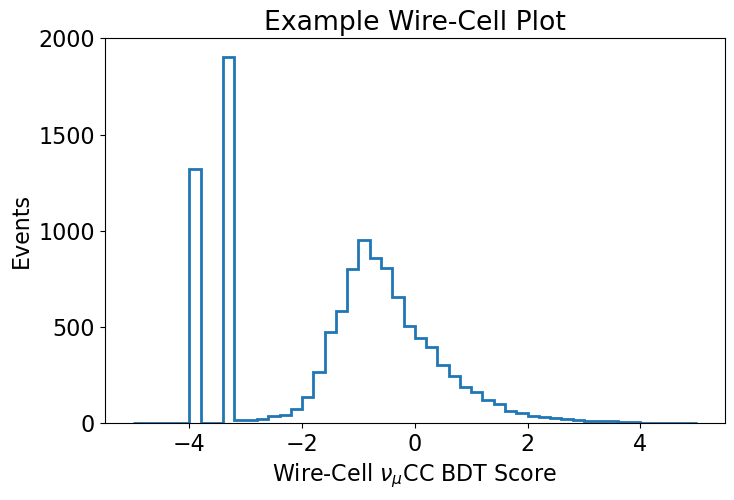

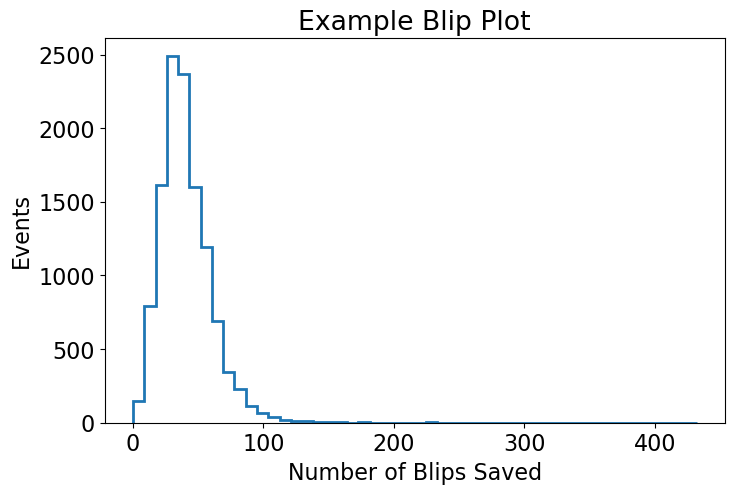

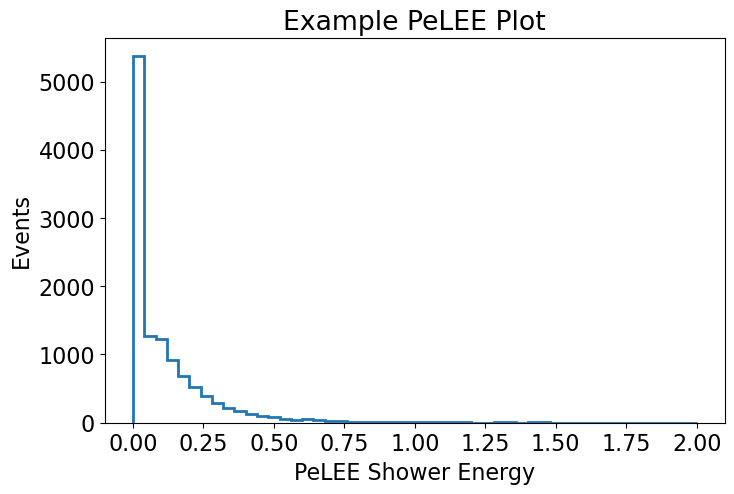

In [14]:
plt.rcParams.update({'font.size': 16})
lw=2

plt.figure(figsize=(8, 5))
plt.hist(all_df["wc_numu_score"], weights=all_df["net_weight"], bins=50, range=(-5, 5), histtype="step", lw=lw)
plt.xlabel(r"Wire-Cell $\nu_\mu$CC BDT Score")
plt.ylabel("Events")
plt.title("Example Wire-Cell Plot")
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(all_df["nblips_saved"], weights=all_df["net_weight"], bins=50, histtype="step", lw=lw)
plt.xlabel(r"Number of Blips Saved")
plt.ylabel("Events")
plt.title("Example Blip Plot")
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(all_df["pelee_shr_energy"], weights=all_df["net_weight"], bins=50, range=(0, 2), histtype="step", lw=lw)
plt.xlabel(r"PeLEE Shower Energy")
plt.ylabel("Events")
plt.title("Example PeLEE Plot")
plt.show()
